<a href="https://colab.research.google.com/github/yhk-8/CCPD-dataset/blob/main/Faster-RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/drive/MyDrive/CCPD_detectron2.zip

In [ ]:
#运行程序,转化格式 记得改一下代码！！！！ +1 可在github我的项目中寻找
!python /content/CCPD_TO_COCO_code/ccpd_to_coco.py --data /content/CCPT_TO_COCO_test 
!python /content/CCPD_TO_COCO_code/make_seg_mask.py 


In [13]:
!rm -r /content/stuffthingmaps

In [73]:
!cp /content/output/model_final.pth /content/drive/MyDrive

In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

In [15]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [16]:
#按照 Detectron2 自定义数据集教程，将自己的数据集注册到 Detectron2。
from detectron2.data.datasets import register_coco_instances

register_coco_instances('self_coco_train', {}, 
                        '/content/drive/MyDrive/ccpd_annotations_train.json', 
                       '/content/CCPD_TO_COC_train')
register_coco_instances('self_coco_val', {}, 
                        '/content/drive/MyDrive/ccpd_annotations_test.json', 
                       '/content/CCPT_TO_COCO_test')


In [17]:
#获取数据的元数据
coco_val_metadata = MetadataCatalog.get("self_coco_val")
dataset_dicts = DatasetCatalog.get("self_coco_val")
coco_val_metadata

[06/06 09:27:41 d2.data.datasets.coco]: Loaded 21200 images in COCO format from /content/drive/MyDrive/ccpd_annotations_test.json


Metadata(evaluator_type='coco', image_root='/content/CCPT_TO_COCO_test', json_file='/content/drive/MyDrive/ccpd_annotations_test.json', name='self_coco_val', thing_classes=['license plate', 'background'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1})

In [ ]:
#原始数据可视化
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coco_val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [86]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
#COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
#COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("self_coco_train",)
cfg.DATASETS.TEST = ("self_coco_val", )
cfg.DATALOADER.NUM_WORKERS = 2
 # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 500 迭代次数
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1   # coco datasets

cfg


CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZ

In [82]:
!cp /content/output/metrics.json /content/drive/MyDrive

In [87]:
import os 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[06/06 11:42:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/06 11:43:05 d2.engine.train_loop]: Starting training from iteration 0
[06/06 11:43:14 d2.utils.events]:  eta: 0:02:06  iter: 19  total_loss: 1.442  loss_cls: 0.605  loss_box_reg: 0.121  loss_mask: 0.683  loss_rpn_cls: 0.025  loss_rpn_loc: 0.004  time: 0.4476  data_time: 0.0156  lr: 0.000005  max_mem: 2882M
[06/06 11:43:23 d2.utils.events]:  eta: 0:02:02  iter: 39  total_loss: 1.363  loss_cls: 0.547  loss_box_reg: 0.142  loss_mask: 0.661  loss_rpn_cls: 0.013  loss_rpn_loc: 0.004  time: 0.4641  data_time: 0.0050  lr: 0.000010  max_mem: 2883M
[06/06 11:43:32 d2.utils.events]:  eta: 0:01:52  iter: 59  total_loss: 1.243  loss_cls: 0.463  loss_box_reg: 0.138  loss_mask: 0.624  loss_rpn_cls: 0.023  loss_rpn_loc: 0.004  time: 0.4631  data_time: 0.0051  lr: 0.000015  max_mem: 2883M
[06/06 11:43:42 d2.utils.events]:  eta: 0:01:44  iter: 79  total_loss: 1.087  loss_cls: 0.352  loss_box_reg: 0.117  loss_mask: 0.575  loss_rpn_cls: 0.023  loss_rpn_loc: 0.004  time: 0.4694  data_time: 0.0053  lr:

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [79]:
#加载已经训练好的模型
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("self_coco_val", )
predictor = DefaultPredictor(cfg)


d: /content/CCPT_TO_COCO_test/0424-19_34-312&439_535&598-511&528_312&598_336&509_535&439-0_0_17_32_23_33_33-129-78.jpg
Instances(num_instances=1, image_height=1160, image_width=720, fields=[pred_boxes: Boxes(tensor([[314.4068, 447.8271, 523.8337, 581.3565]], device='cuda:0')), scores: tensor([0.9629], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])
pre:


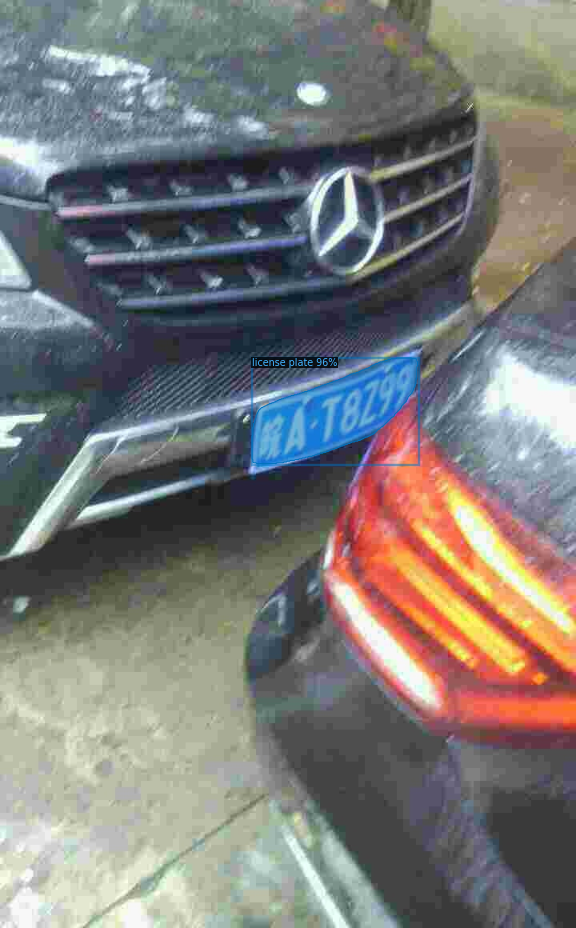

actual


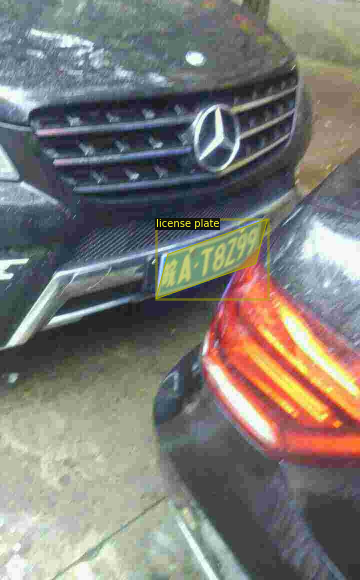

In [91]:
#预测结果可视化
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 1): 
    print('d:',d['file_name'])   
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs['instances'])
    print('pre:')
    v = Visualizer(im[:, :, ::-1],
                   metadata=coco_val_metadata, 
                   scale=0.8, 
                     # remove the colors of unsegmented pixels
    )
    
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #v = v.draw_sem_seg(sem_seg, area_threshold=None, alpha=0.8)
    
    cv2_imshow(v.get_image()[:, :, ::-1])
    print("actual")
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=coco_val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])
